In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# initialize the initial learning rate, number of epochs to train for,and batch size
INIT_LR=1e-4
EPOCHS=10
BS=100

In [3]:
# r before string will prevent Python from interpreting escape characters.
DIRECTORY=r"D:\AI Course\Deep Learning\Blind Detection\dataset"
CATEGORIES=["blind","not_blind"]

In [4]:
# grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images
print("[INFO] loading images...")

data=[]
labels=[]

[INFO] loading images...


In [5]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image=img_to_array(image)
        image=preprocess_input(image)
        
        data.append(image)
        labels.append(category)

In [6]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

#Train and test set split
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [7]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [8]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel=MobileNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))

In [9]:
# construct the head of the model that will be placed on top of the base model(NN)
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [10]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model=Model(inputs=baseModel.input,outputs=headModel)

In [11]:
#loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable=False

In [12]:
# compile our model
print("[INFO] compiling model...")

from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define decay steps and decay rate
decay_steps = 1000  # Typically number of steps before applying decay
decay_rate = 0.95   # Decay rate

lr_schedule = ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=decay_steps,  # define the number of steps for decay
    decay_rate=decay_rate,    # define the decay rate
    staircase=True            # whether to apply decay at discrete intervals
)
# Assuming INIT_LR and EPOCHS are defined somewhere in your code
opt = Adam(learning_rate=lr_schedule)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Assuming INIT_LR and EPOCHS are defined somewhere in your code
#opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
#model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,
              validation_data=(testX, testY),validation_steps=len(testX) // BS,epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/10
19/19 [==============================] - 134s 7s/step - loss: 0.6505 - accuracy: 0.6758 - val_loss: 0.3767 - val_accuracy: 0.7857
Epoch 2/10
19/19 [==============================] - 122s 6s/step - loss: 0.3703 - accuracy: 0.8487 - val_loss: 0.2349 - val_accuracy: 0.9510
Epoch 3/10
19/19 [==============================] - 127s 7s/step - loss: 0.2413 - accuracy: 0.9413 - val_loss: 0.1642 - val_accuracy: 0.9735
Epoch 4/10
19/19 [==============================] - 121s 6s/step - loss: 0.1810 - accuracy: 0.9612 - val_loss: 0.1251 - val_accuracy: 0.9755
Epoch 5/10
19/19 [==============================] - 123s 6s/step - loss: 0.1527 - accuracy: 0.9688 - val_loss: 0.1012 - val_accuracy: 0.9776
Epoch 6/10
19/19 [==============================] - 214s 11s/step - loss: 0.1210 - accuracy: 0.9763 - val_loss: 0.0852 - val_accuracy: 0.9776
Epoch 7/10
19/19 [==============================] - 122s 6s/step - loss: 0.0961 - accuracy: 0.9779 - va

In [13]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs=model.predict(testX,batch_size=BS)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs,axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1),predIdxs,target_names=lb.classes_))

#serialize the model to disk
print("[INFO] saving blind detector model...")
model.save("Blind_detector.h5")

[INFO] evaluating network...
5/5 [==============================] - 24s 4s/step
              precision    recall  f1-score   support

       blind       0.95      0.96      0.96       107
   not_blind       0.99      0.99      0.99       383

    accuracy                           0.98       490
   macro avg       0.97      0.97      0.97       490
weighted avg       0.98      0.98      0.98       490

[INFO] saving blind detector model...


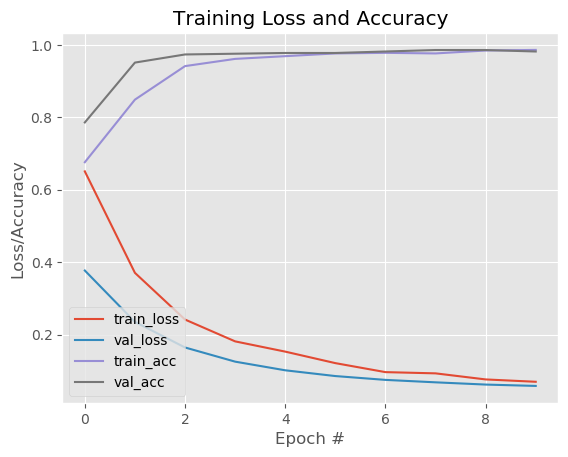

In [14]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")